In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 데이터 불러오기
df = pd.read_csv("https://github.com/MyungKyuYi/AI-class/raw/main/TSLA.csv")

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [3]:
# 시퀀스 데이터 생성 함수
def make_sequences(df, window=60):
    X, y = [], []
    features = df[['Open', 'High', 'Low']].values
    target = df['Close'].values
    for i in range(len(df) - window):
        X.append(features[i:i+window])
        y.append(target[i+window])
    return np.array(X), np.array(y)

window = 60
X, y = make_sequences(df, window)

In [4]:
# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

scaler_X = MinMaxScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[2])
scaler_X.fit(X_train_2d)
X_train_scaled = scaler_X.transform(X_train_2d).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [5]:
# 모델 정의
def build_rnn(window=60, n_features=3, units=64):
    model = Sequential([
        SimpleRNN(units, input_shape=(window, n_features)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(window=60, n_features=3, units=64):
    model = Sequential([
        LSTM(units, input_shape=(window, n_features)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [6]:
# RNN / LSTM 학습
rnn_model = build_rnn(window, 3, 64)
lstm_model = build_lstm(window, 3, 64)

print("\n--- RNN 학습 ---")
hist_rnn = rnn_model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)

print("\n--- LSTM 학습 ---")
hist_lstm = lstm_model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=2
)


--- RNN 학습 ---
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 - 3s - 40ms/step - loss: 0.0025 - val_loss: 3.2681e-04
Epoch 2/20
66/66 - 1s - 15ms/step - loss: 9.1840e-04 - val_loss: 5.1163e-04
Epoch 3/20
66/66 - 1s - 12ms/step - loss: 8.8172e-04 - val_loss: 2.5208e-04
Epoch 4/20
66/66 - 1s - 19ms/step - loss: 6.0568e-04 - val_loss: 2.6810e-04
Epoch 5/20
66/66 - 1s - 12ms/step - loss: 5.5458e-04 - val_loss: 1.7128e-04
Epoch 6/20
66/66 - 1s - 13ms/step - loss: 5.0053e-04 - val_loss: 9.4445e-05
Epoch 7/20
66/66 - 1s - 19ms/step - loss: 4.4800e-04 - val_loss: 5.1262e-04
Epoch 8/20
66/66 - 2s - 31ms/step - loss: 3.3438e-04 - val_loss: 9.0669e-05
Epoch 9/20
66/66 - 1s - 19ms/step - loss: 4.1201e-04 - val_loss: 4.7411e-04
Epoch 10/20
66/66 - 1s - 19ms/step - loss: 3.5568e-04 - val_loss: 2.9940e-04
Epoch 11/20
66/66 - 1s - 12ms/step - loss: 3.6221e-04 - val_loss: 5.3081e-04
Epoch 12/20
66/66 - 1s - 19ms/step - loss: 4.6144e-04 - val_loss: 3.9133e-04
Epoch 13/20
66/66 - 1s - 19ms/step - loss: 4.0930e-04 - val_loss: 1.0010e-04
Epoch 14/20
66/66 - 1s 


RNN → MSE: 1245.7486


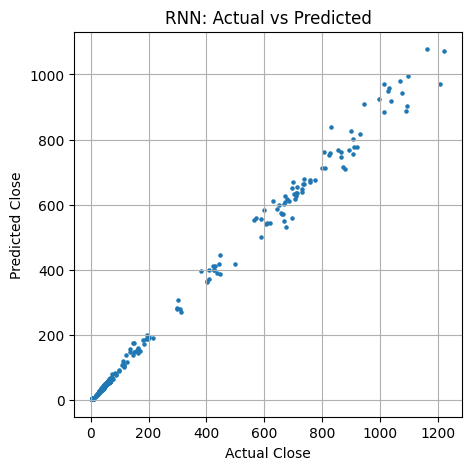


LSTM → MSE: 465.1454


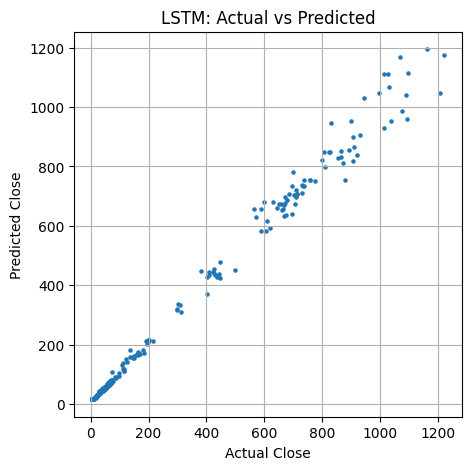

In [7]:
# 평가 및 시각화
def evaluate_and_plot(model, name):
    pred_scaled = model.predict(X_test_scaled, verbose = 0)
    pred = scaler_y.inverse_transform(pred_scaled)
    mse = mean_squared_error(y_test, pred)
    print(f"\n{name} → MSE: {mse:.4f}")

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, pred, s=5)
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid(True)
    plt.show()

    return pred

_ = evaluate_and_plot(rnn_model, "RNN")
_ = evaluate_and_plot(lstm_model, "LSTM")